\section*{4.1 Bias Frames}
Section 4.1 is the analysis for bias frames. In this we will calculate the amount of read out noise from the CCD and identify any hot pixels to be used for later calibration. I first loaded the bias fits file into python so to create a histogram.

To find the average number of counts per pixel I used python to create a histogram of the number of counts per pixel of the bias image. When plotted with a log y-axis it is easier to determine where the majority of counts are, as there is a peak that is over two orders of magnitude higher than the background. For this set of data I decided to cut off any data points that had more than 1300 counts. The fraction of pixels that were over 1300 counts was $1.62 * 10^{-5}$. I used the width of this peak to determine where the cutoff for the data for the gaussian should be. For this bias image I used data between 950 counts and 1050 counts. Using all the pixels that had counts within that range I calculated the mean and standard deviation which were $\mu = 985.9$ counts and $\sigma = 8.1$ counts

The gain listed in the images header was 2.06. Converting this to number of electrons results $N_{electrons}=GN_{counts}=8.1*2.06=16.7 \,e-$. The listed read out noise on the spec sheet is $14.8e-$ 

Fraction of rejected pixels 1.621246337890625e-05
Average value 985.923783029866
Standard deviation 8.098709046392562


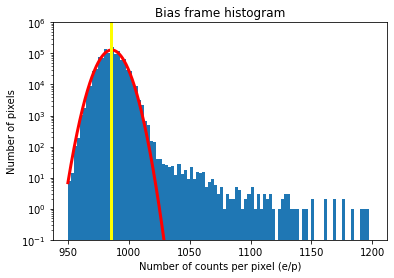

In [6]:
import numpy as np
from astropy.io import fits
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
%matplotlib inline

bias_image=fits.open('0cbias.FIT')
bias_1d = bias_image[0].data.flatten()

cmin=950
cmax=1200
nbins=100
normalization=(cmax-cmin)/nbins*len(bias_1d[(bias_1d>=cmin) & (bias_1d<=cmax)])

clipmin=cmin
clipmax=1030
clippedvalues = bias_1d[(bias_1d>=clipmin) & (bias_1d<=clipmax)]

cutvalues = bias_1d[(bias_1d>=1300)]
fraction_pix = len(cutvalues)/len(bias_1d)
print("Fraction of rejected pixels " + str(fraction_pix))

mu=np.mean(clippedvalues)
sig=np.std(clippedvalues)
mode=stats.mode(clippedvalues)[0][0]

print('Average value ' + str(mu))
print('Standard deviation ' + str(sig))

xarray=np.linspace(cmin,cmax,nbins*10)
yarray=normalization*norm.pdf(xarray,loc=mu, scale=sig)

plt.hist(bias_1d,range=[cmin,cmax], bins=nbins);
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(xarray,yarray,color="red",linewidth=3.0)
plt.axvline(x=mode,linewidth=3.0,color="yellow")

header = bias_image[0].header
gain = header['EGAIN']
muNelectron = gain * sig
#print(muNelectron)

plt.xlabel('Number of counts per pixel (e/p)')
plt.ylabel('Number of pixels')
plt.title('Bias frame histogram')


plt.show()

\section{4.2 Dark Frames}

Part 1 Creating the master dark:
To create the master dark I first loaded all 10 darks into python, then I could loop trhough every pixel and find the median count value from all 10 darks. That median was then loaded into a new master dark array and after evaluating over every pixel I had a new array whos data in each pixel was the median value. I then made a new master dark FITS file.
The hotest pixels I found were at (199,496) and (330,410). These pixels were entirely saturated and had counts above 61,000. There were other hot pixels however they had counts roughly around 20,000. Every hot pixel I found was present on each of the ten darks as well as the master dark.

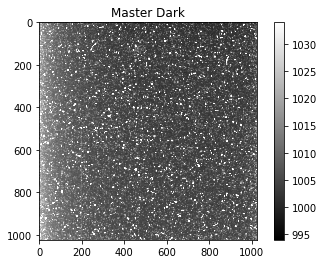

In [17]:
import numpy as np
from astropy.io import fits
data= np.zeros((10, 1024, 1024))
master_dark = np.zeros((1024,1024))
%matplotlib inline
for i in range (0,10):
    file = "10dark_" + str(i) +".FIT"
    dark = fits.open(file)
    current_dark=dark[0].data
    #print(current_dark)
    for n in range(0,1024):
        for j in range(0,1024):
            data[i,n,j]=current_dark[n,j]

median_list=[]
for n in range(0,1024):
    for j in range(1024):
        median_list.clear()
        for i in range(0,10):
            median_list.append(data[i,n,j])
        master_dark[n,j] = np.median(median_list)
#print(master_dark)

new_dark = fits.PrimaryHDU(master_dark)
new_dark.writeto('master_dark.fits',overwrite=True)

plt.imshow(master_dark, cmap='gray')
plt.colorbar()
plt.title('Master Dark')
plt.clim(994, 1034)
plt.show()

Part 2 Time series of dark frames
The seven darks for this section all have different exposure times starting with picture 0 at 10 seconds and increasing by 20 seconds for each picture, ending at 130 seconds at picture 6. I started the analysis for this section by loading all seven FITS files into python arrays. Then I performed a similar step to the bias frame section to find the upper cutoff to make a gaussian. I started this by plotting each dark as a histogram by the number of counts with a logorithmic y axis. From this graph I could estimate the cutoff by using the width of the peak to find the upper cutoff. I estimated the cutoffs at 1025,1030,1050,1065,1075,1100,1120 for each of the darks. The number of counts detected increased as the exposure time increased. This is because there was more time for the dark current to register false counts even though there was no light hitting the detector. 
For the remaining data points within the cutoff I plotted them onto a gaussian and calculated the mean and standard deviation for each of the images. To find the uncertainty on the mean I used the formula $\sigma_{\bar{x}}=\frac{\sigma_x}{\sqrt{N}}$, where $\sigma_{\bar{x}}$ is the uncertainty on the mean and N is the number of pixels in the image.

I then made a scatter plot of average number of counts vs exposure time, with error bars that had length of $\sigma_{\bar{x}}$ and fit the plot with a line of best fit. 

To calculate the dark current per pixel per second I used the slope of the graph of average number of counts vs exposure time. I found that the $I_{dk}=N_{electrons}/\Delta t=GN_{counts}/\Delta t$. The slope of the graph is $N_{counts}/\Delta t$ so then $I_{dk}=2.06*slope$. Plugging in my value for the slope I get $I_{dk}=1.296e^-/p/s$. The listed value for dark current at 0 celcius is $9e^-/p/s$

dark current: 0.6484836552131683+-0.33281872606672236 electrons/pixel/second


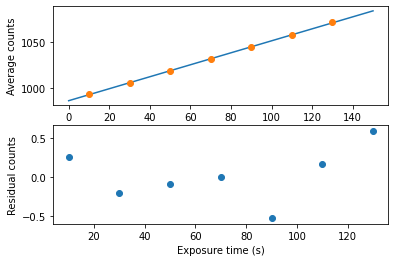

In [46]:
import numpy as np
from astropy.io import fits
import matplotlib
matplotlib.use('TkAgg')
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
%matplotlib inline


data= np.zeros((7, 1024, 1024))

for i in range (0,7):
    file = "timedark" + str(i) + ".FIT"
    timedark = fits.open(file)
    current_dark=timedark[0].data
    #print(current_dark)
    for n in range(0,1024):
        for j in range(0,1024):
            data[i,n,j]=current_dark[n,j]



upper_bound = [1025,1030,1050,1065,1075,1100,1120]

data_within = []
mu = []
std = []
statstd = []
leftovermu = []
for n in range(0,7):
    current_data = data[n].flatten()
    data_within.append(current_data[(current_data>=np.min(current_data)) & (current_data <= upper_bound[n])])

    mu.append(np.average(data_within[n]))
    std.append(np.std(data_within[n]))
    statstd.append(std[n]/math.sqrt(len(data_within[n])))


#print(mu)
exptime = [10,30,50,70,90,110,130]

#plt.errorbar(exptime, mu, yerr=statstd,fmt='o', label="data")
#plt.xlabel('Exposure time (s)')
#plt.ylabel('Average number of counts')

def func(x,a,b):
    return a+b*x
best_vals, covar = curve_fit(func, exptime, mu, sigma=statstd)
a=best_vals[0]
b=best_vals[1]

a_list = [a,a,a,a,a,a,a]
b_list = [b,b,b,b,b,b,b]
x = np.linspace(0, 150, num=100)
yfit = func(x,a,b)
#plt.plot(x,yfit,label="fit")
residuals =[]
for i in range(len(exptime)):
    residuals.append(mu[i] - func(exptime[i],a,b))


#print(residuals)
#print(b)
#plt.errorbar(exptime,residuals, yerr=statstd,fmt='o',label="residuals")
#errorbar(exptime, mu, yerr=statstd,fmt='o', label="data")
slope_sig = np.std(residuals)
#print(str(b) +"+-"+ str(slope_sig))


fig, ax = plt.subplots(2)
#fig.errorbar(exptime, mu, yerr=statstd,fmt='o', label="data")
ax[0].plot(x,yfit,label="fit")
ax[0].errorbar(exptime, mu, yerr=statstd,fmt='o', label="data")
ax[1].errorbar(exptime,residuals, yerr=statstd,fmt='o',label="residuals")

ax[0].set_xlabel('Exposure time (s)')
ax[1].set_ylabel('Residual counts')
ax[0].set_ylabel('Average counts')
ax[1].set_xlabel('Exposure time (s)')
print('dark current: ' + str(b) +"+-"+ str(slope_sig)+' electrons/pixel/second')


plt.show()

Section 4.3

To generate the master flat field I loaded all 10 flats and took the median value of each pixel and used that to create a new master flat FITS file. This fits file was generally brighter in the middle of the image and darker at the edges. It also had many ring artifacts from the telescope internals. When comparing the bright sections in the middle to the dark outer sections, the inner sections were roughly 10% brighter. This would cause a change in magnitude of 0.1 $$\Delta m = 2.5 log_{10}\left(\frac{1.1*F}{F}\right)$$
Dead pixels are pixels that do not register any counts no matter how much light is collected. To identify any dead pixels I counted the number of pixels that had counts less than 50 and there were not any.
As flat fields are measurements of the uncertainty and sensitivity of the camera and telescope it is possible to take flats on another night. However the camera must be set to the same temperature as the original measurements.

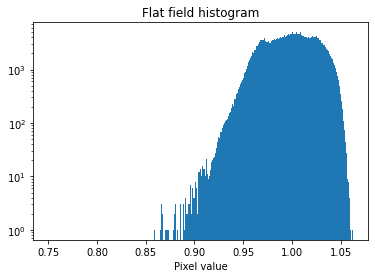

Lowest pixel value
0.8533377250768555


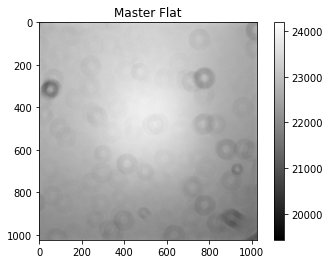

In [31]:
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt

list = []
for i in range(3,13):
    file = "flat" + str(i) + ".FIT"
    flat_file = fits.open(file)
    flat_data = flat_file[0].data
    list.append(flat_data)
data = np.reshape(list,(len(list),1024,1024))
master_flat = np.array(np.median(data, axis=0))
norm_master = master_flat / np.median(list)
#print(norm_master)

flat_norm = norm_master.flatten()
plt.hist(flat_norm,range=[0.75,np.max(flat_norm)], bins=1000);
plt.yscale('log')
plt.title('Flat field histogram')
plt.xlabel('Pixel value')
plt.show()
print("Lowest pixel value")
print(np.min(flat_norm))

plt.imshow(master_flat, cmap='gray')
plt.colorbar()
plt.title('Master Flat')
#plt.clim(994, 1034)

norm_master_fit = fits.PrimaryHDU(norm_master)
norm_master_fit.writeto('master_flat.FITS',overwrite=True)

Section 4.4

The spectrograph flat we took showed 3 horizontal lines corresponding to the three slits on the spectrograph. For our spectrograph flat the topmost line corresponded to the 35$\mu$m slit, the middle slit was the 25$\mu$m, and the bottom line was the 50$\mu$m slit. As the 50$\mu$m slit is the widest it will let in the most light causing it to be the brightest of the three slits. Conversly the 25$\mu$m slit will be the darkest with the 35$\mu$m being inbetween them in brightness. 
The spectrograph CCD had a size of 510x765 pixels and the 50$\mu$m slit was between rows 45 and 168. To make a plot of the flat-field values vs dispersion axis I first loaded the flat into python and discarded all data that wasnt within the selected range. I then took a median value of each column for all 765 columns and plotted it against its column position. 
To normalize the graph I fitted it with a degree 4 polynomial and divided the median column value by the polynomial at that position. The polynomial was chosen to be a degree 4 as it fit closly to the general trend of the data without providing too much detail in the fluctuations. This normalized data is how sensitive the combined telescope and spectromoter setup is along its dispersion axis. This does not tell us how sensitive each pixel is individually as it is impossible to tell weather changes in sensitivity are in response to the spectrometer or to the intrinsic sensitivity of the pixel.
I found that the rows that the lamp spectrum was withing was rows 47-165. I then found the median value of each column across the length of the picture. Then by dividing by the normilization polynomial I found earlier I can find the true response of each pixel. This response should look be very low except for the columns where an emmision line was present. I then plotted this against the column position along the camera.


Spectrum Calibration 4.4.5
When we took data we did not line up the spectrograph correctly with the 5852 angstrom line. This meant that we had to figure out which part of the neon spectrum we had. We did this by lining up our spectrum with the known neon spectrum and trying to find lines that matched up. The magnitude of the lines varies between the two graphs and I believe that this is due to different intensities of light and different temperatures of the source lamp. We ended up finding that the tallest line at pixel position x=410 corresponded to 6402 angstrom line. From there we matched up the rest of the peaks with the known wavelengths. Next we had to figure out the dispersion of the spectrograph or how many angstroms each pixel covered. To find this we used our spectrum to find at what pixel position we had a known peak. We then plotted the wavelength versus the pixel position and fit a line to the graph. The slope of the trendline would be equal to the wavelength covered by each pixel. We found that the dispersion of our spectrum was 0.98 angstroms per pixel. The spectrograph CCD was 765 pixels wide which gave us a wavelength range of 752.3 angstroms.

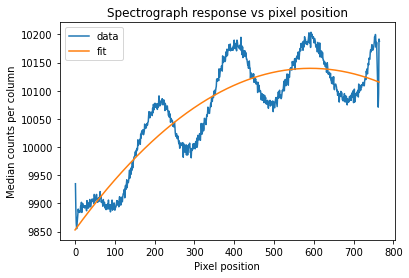

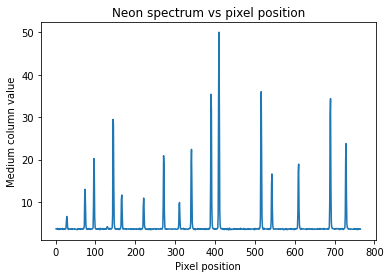

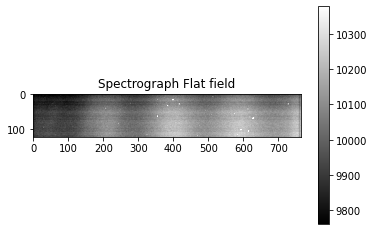

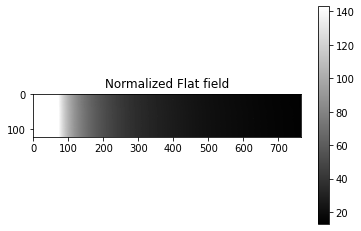

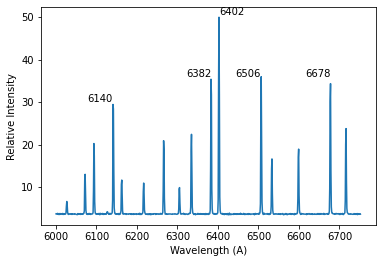

The wavelength covered by the graph is 752.5943488179873 angstroms
The dispersion of the spectroscope is 0.983783462507173 angstroms per pixel


In [43]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

flat = fits.open('specwithauto_flat.00000010.NOAUTODARK.FIT')
fulldata = flat[0].data
data = fulldata[45:168]
column_median = np.median(data,axis=0)
x_axis =np.linspace(1,len(column_median),len(column_median))
data_file = fits.PrimaryHDU(data)
#data_file.writeto('flat_section.FITS')

deg = 2
poly = np.polyfit(x_axis,column_median,deg=deg)

def func(x):
    sum = 0
    for i in range(0,deg):
        sum += x * (poly[i] ** (i+1))
    return sum

fig, ax2 = plt.subplots()
ax2.plot(x_axis,column_median,label='data');
ax2.plot(np.polyval(poly, x_axis), label='fit')
ax2.legend()
plt.title('Spectrograph response vs pixel position')
plt.xlabel('Pixel position')
plt.ylabel('Median counts per column')

#______________________________________________________________________________________________

scpectrum_file = fits.open('arclampspectrum.FIT')
spectrum_full = scpectrum_file[0].data
spectrum_rows = spectrum_full[45:168]#/ (data/func(x_axis))
spectrum_median = np.median(spectrum_rows,axis=0)
spectrum_norm = spectrum_median / np.median(data/func(x_axis))
fig, spectrum_plot = plt.subplots()
spectrum_plot.plot(x_axis,spectrum_norm)
plt.title('Neon spectrum vs pixel position')
plt.xlabel('Pixel position')
plt.ylabel('Medium column value')
new_flat_file = fits.PrimaryHDU(data/ func(x_axis))
new_flat_file.writeto('flat_section_new.FITS',overwrite=True)

plt.show()


plt.imshow(data, cmap='gray')
plt.colorbar()
plt.clim(9762, 10378)
plt.title('Spectrograph Flat field')
plt.show()

plt.imshow(data/func(x_axis),cmap='gray')
plt.colorbar()
plt.clim(13,143)
plt.title('Normalized Flat field')
plt.show()


wavelength_per_pix =  0.963 #angstrom per pixel


#fig, ax3 = plt.subplots()
#ax3.plot(pix_to_wavelength(x_axis),spectrum_norm)
#plt.xlabel('Wavelength (A)')
plt.show()
def line(x):
    point = wavelength_poly[0]*x + wavelength_poly[1]
    return point
peak_x = [410,390,341,516,311,271,690]
peak_lambda = [6402.25,6382.99,6334.43,6506.53,6304.79,6266.49,6678.28]

wavelength_poly = np.polyfit(peak_x,peak_lambda,deg=1)
wavelength_slope = wavelength_poly[0]

#xprint(wavelength_slope)
#plt.scatter(peak_x,peak_lambda)
plt.show()
plt.plot(line(x_axis),spectrum_norm)
plt.xlabel('Wavelength (A)')
plt.ylabel('Relative Intensity')

plt.text(6402.25,50.5,'6402',horizontalalignment='left')
plt.text(6382.99,36,'6382',horizontalalignment='right')
plt.text(6506.53,36,'6506',horizontalalignment='right')
plt.text(6678.28,36,'6678',horizontalalignment='right')
plt.text(6140,30,'6140',horizontalalignment='right')

plt.show()

print('The wavelength covered by the graph is ' +str(line(765)-line(0))+' angstroms')
print('The dispersion of the spectroscope is '+str((line(765)-line(0))/765)+ " angstroms per pixel")

Section 4.5 Calibration Strategies

In general there are three types of calibration images, bias frames, darks, and flats. Bias frames measure the noise caused by reading the CCD, they are taken at a 0s exposure with no light. For our setup bias frames are less important than other calibration strategies as the read out noise is dominated by other sources of error like dark current. Darks are images taken with a closed shutter and the same exposure time as actual images. Darks measure the dark current or the number of electrons that quantum tunnel through the conduction band and register as counts without a photon causing it. The amount of dark current is highly dependent on the temperature of the CCD and can almost be completly eliminated with enough cooling. As out CCD is not cooled to that extent the noise from the dark current is high when compared to the read out noise. The last type of calibration are flat fields. Flats are images used to correct for the differences in sensitivity of each pixel as well as the light they each get from an even source. As the pixels in a CCD are not perfect some will register more counts than others even if the amount of light they receive is the same. In addition vignetting from the telescope internals cause some pixels to receive more light than others. For out setup this looks like many small rings that are scattered across the image. As both bias frames and darks receive no  llight they can be taken at any time as long as the same temperature and exposure time is used. Unlike bias frames and darks which measure properties of only the CCD, flats are dependent on the setup of the CCD and the telescope and the orientation of each relative to eachother. This means that flats must be taken on the same night as science images. 
All three of the images are used to correct science images in different ways. Bias and darks add extra counts to a science image without light causing it. To correct for this the bias frames and darks can be subtracted from the science image. Once a master flat has been normalized around 1 the science image can be divided by the flat to recover the counts the pixel should have received. 


Talk about why we use medians for the master darks/flats